# Kadaster dataset insights

This notebook analyzes the JSON files produced by `kadaster.py`.

It focuses on:
- Execution error rate and most common error messages
- Empty result rate (e.g. `results.bindings == []`)
- Query types (SELECT/CONSTRUCT/ASK/DESCRIBE) and patterns (SERVICE, LIMIT, prefixes)
- Metadata distributions (owners, visualization, dataset_name)
- Duplicates and outliers


## Setup

If you don't have analysis dependencies installed yet:

```bash
uv sync
uv run python -m ipykernel install --user --name ais-kadaster-mcp --display-name "ais-kadaster-mcp"
```


In [67]:
from __future__ import annotations

import json
import os
import re
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Any

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


In [68]:
# Configure where the JSON files live
DEFAULT_OUTPUT_DIR = os.getenv("KADASTER_OUTPUT_DIR", "kadaster_dataset")
DATA_DIR = Path(DEFAULT_OUTPUT_DIR)
if not DATA_DIR.exists():
    DATA_DIR = (Path("..") / DEFAULT_OUTPUT_DIR).resolve()

DATA_DIR, DATA_DIR.exists()

(WindowsPath('C:/Development/ais-kadaster-mcp/kadaster_dataset'), True)

In [69]:
paths = sorted(DATA_DIR.glob("*.json"))
len(paths), paths[:3]

(365,
 [WindowsPath('C:/Development/ais-kadaster-mcp/kadaster_dataset/62b327c30e997990799accd3.json'),
  WindowsPath('C:/Development/ais-kadaster-mcp/kadaster_dataset/62b3287a0e997990799acdcb.json'),
  WindowsPath('C:/Development/ais-kadaster-mcp/kadaster_dataset/62b328e60e997990799ace5d.json')])

## Load + normalize

Each JSON file should roughly match this shape:
- `meta`: id/name/description/owner/visualization
- `prompt_context`: prefixes/dataset_name
- `output_sparql`: the query
- `execution_result_sample`: SPARQL endpoint response or `{error: ...}`


In [70]:
def read_json(path: Path) -> dict[str, Any] | None:
    try:
        return json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        return None


raw = []
bad = []
for p in paths:
    obj = read_json(p)
    if obj is None:
        bad.append(p)
    else:
        raw.append(obj)

len(raw), len(bad)

(365, 0)

In [71]:
df = pd.json_normalize(raw)
df.columns = [c.replace(".", "_") for c in df.columns]
df.head(3)

,input_natural_language,output_sparql,meta_id,meta_name,meta_description,meta_owner,meta_visualization,prompt_context_prefixes,prompt_context_dataset_name,execution_result_sample_head_vars,execution_result_sample_results_bindings,execution_result_sample_result_format,execution_result_sample_status_code,execution_result_sample_content_type,execution_result_sample_text_sample,execution_result_sample_error,execution_result_sample_boolean,execution_result_sample_info
0,,prefix sdo: <https://schema.org/>\nprefix xsd:...,62b327c30e997990799accd3,recommender-system,,Stichting Koninklijk Nederlands Normalisatie I...,table,"[{'prefixLabel': 'graph', 'iri': 'https://data...",Catalog,"[huidigeStandaard, suggestieStandaard, titel, ...",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,prefix sdo: <https://schema.org/>\nconstruct {...,62b3287a0e997990799acdcb,related-standards,,Stichting Koninklijk Nederlands Normalisatie I...,network,"[{'prefixLabel': 'graph', 'iri': 'https://data...",Catalog,NaN,NaN,turtle,200.0,text/turtle; charset=UTF-8,,NaN,NaN,NaN
2,,prefix sdo: <https://schema.org/>\nselect ?woo...,62b328e60e997990799ace5d,word-counts,,Stichting Koninklijk Nederlands Normalisatie I...,gchart,"[{'prefixLabel': 'graph', 'iri': 'https://data...",Catalog,"[woord, aantalStandaarden]",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
def ensure_list(value: Any) -> list[Any]:
    if value is None:
        return []
    if isinstance(value, list):
        return value
    return [value]


df["prompt_context_prefixes"] = df.get("prompt_context_prefixes", pd.Series([[]] * len(df))).apply(ensure_list)
df["prefix_count"] = df["prompt_context_prefixes"].apply(len)

df["output_sparql"] = df.get("output_sparql", pd.Series([None] * len(df))).astype("string")
df["sparql_len"] = df["output_sparql"].fillna("").map(len)

df[["meta_id", "meta_name", "meta_owner", "meta_visualization", "prefix_count", "sparql_len"]].head(5)

,meta_id,meta_name,meta_owner,meta_visualization,prefix_count,sparql_len
0,62b327c30e997990799accd3,recommender-system,Stichting Koninklijk Nederlands Normalisatie I...,table,6,1554
1,62b3287a0e997990799acdcb,related-standards,Stichting Koninklijk Nederlands Normalisatie I...,network,6,247
2,62b328e60e997990799ace5d,word-counts,Stichting Koninklijk Nederlands Normalisatie I...,gchart,6,230
3,62b329645be4191ce3b65583,related-words,Stichting Koninklijk Nederlands Normalisatie I...,network,6,267
4,62b338c30e997990799ae29d,voorzieningen-vergelijking,Centraal Bureau voor de Statistiek (CBS),gchart,10,837


## Basic coverage


In [73]:
coverage = {
    "rows": len(df),
    "has_sparql": int(df["output_sparql"].notna().sum()),
    "missing_sparql": int(df["output_sparql"].isna().sum()),
    "has_exec_result": int(df.get("execution_result_sample", pd.Series([None] * len(df))).notna().sum()),
}
coverage

{'rows': 365, 'has_sparql': 361, 'missing_sparql': 4, 'has_exec_result': 0}

## Query parsing helpers

We infer query type and a few structural patterns using regexes.


In [74]:
QUERY_TYPE_RE = re.compile(r"\b(select|construct|ask|describe)\b", re.IGNORECASE)
PREFIX_RE = re.compile(r"^\s*prefix\s+([^:\s]+):\s*<([^>]+)>\s*$", re.IGNORECASE | re.MULTILINE)


def infer_query_type(q: Any) -> str | None:
    if not isinstance(q, str) or not q.strip():
        return None
    m = QUERY_TYPE_RE.search(q)
    return m.group(1).upper() if m else None


def has_service(q: Any) -> bool:
    if not isinstance(q, str) or not q.strip():
        return False
    return bool(re.search(r"\bservice\b", q, flags=re.IGNORECASE))


def infer_limit(q: Any) -> int | None:
    if not isinstance(q, str) or not q.strip():
        return None
    m = re.search(r"\blimit\s+(\d+)\b", q, flags=re.IGNORECASE)
    return int(m.group(1)) if m else None


def extract_prefix_decls(q: Any) -> list[tuple[str, str]]:
    if not isinstance(q, str) or not q.strip():
        return []
    return [(pfx, iri) for (pfx, iri) in PREFIX_RE.findall(q)]


In [75]:
df["query_type"] = df["output_sparql"].map(infer_query_type)
df["has_service"] = df["output_sparql"].map(has_service)
df["limit"] = df["output_sparql"].map(infer_limit)
df["declared_prefixes"] = df["output_sparql"].map(extract_prefix_decls)
df["declared_prefix_count"] = df["declared_prefixes"].map(len)

df[["meta_id", "query_type", "has_service", "limit", "declared_prefix_count"]].head(10)

,meta_id,query_type,has_service,limit,declared_prefix_count
0,62b327c30e997990799accd3,SELECT,False,NaN,2
1,62b3287a0e997990799acdcb,CONSTRUCT,False,NaN,1
2,62b328e60e997990799ace5d,SELECT,False,10.0,1
3,62b329645be4191ce3b65583,CONSTRUCT,False,NaN,1
4,62b338c30e997990799ae29d,SELECT,False,NaN,4
5,62b3399c5be4191ce3b65f3e,SELECT,False,NaN,5
6,62b33af20e997990799ae591,SELECT,False,NaN,7
7,62b346430e997990799aee5d,SELECT,True,NaN,5
8,62b346ec0e997990799aef2f,SELECT,True,NaN,5
9,62b347680e997990799aefd4,SELECT,True,NaN,5


## Execution results: errors vs empty results

We classify:
- **error**: `execution_result_sample.error` present
- **empty**: `results.bindings` exists but is an empty list
- **non-empty**: `results.bindings` exists and has >= 1 binding
- **boolean**: ASK queries returning `{boolean: ...}`
- **unknown**: everything else (e.g. truncated response, non-JSON response wrapper)


In [76]:
def classify_exec(exec_obj: Any) -> str:
    if not isinstance(exec_obj, dict):
        return "missing"
    if exec_obj.get("error"):
        return "error"
    # Non-JSON (e.g. CONSTRUCT/DESCRIBE returning Turtle)
    if exec_obj.get("result_format") in {"turtle", "text"}:
        return "rdf" if exec_obj.get("result_format") == "turtle" else "text"
    if "boolean" in exec_obj:
        return "boolean"
    results = exec_obj.get("results")
    if isinstance(results, dict):
        bindings = results.get("bindings")
        if isinstance(bindings, list):
            return "empty" if len(bindings) == 0 else "non_empty"
    return "unknown"


exec_objs = pd.Series([obj.get("execution_result_sample") for obj in raw])
df["exec_class"] = exec_objs.map(classify_exec)
df["exec_class"].value_counts(dropna=False)

exec_class
empty        249
error         46
non_empty     41
rdf           24
unknown        4
boolean        1
Name: count, dtype: int64

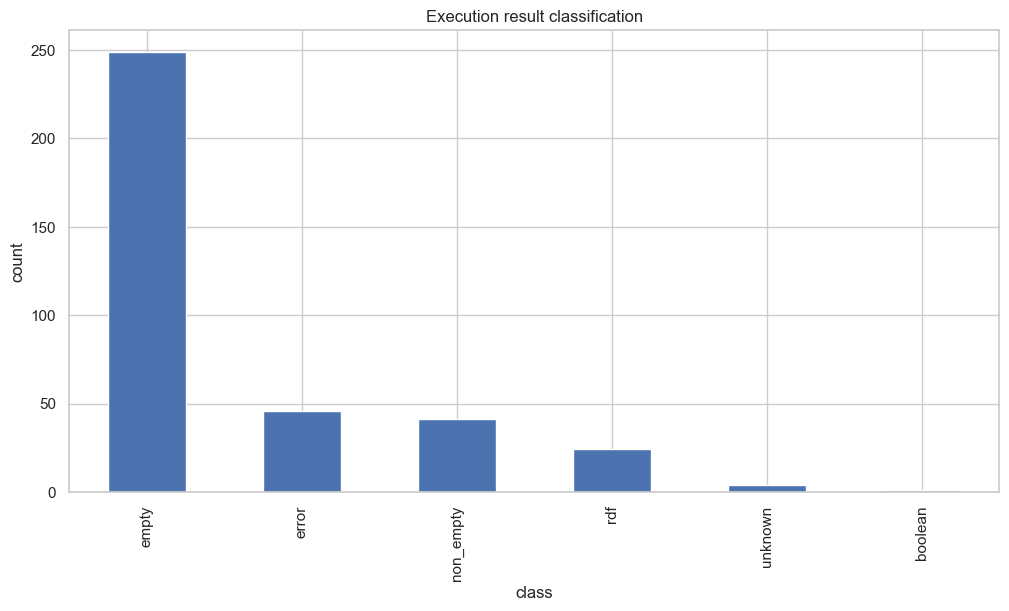

In [77]:
PALETTE = {
    "non_empty": "#2ca02c",  # green
    "boolean": "#1f77b4",    # blue
    "rdf": "#17becf",        # teal
    "text": "#8c564b",       # brown
    "empty": "#ff7f0e",      # orange
    "unknown": "#9467bd",    # purple
    "missing": "#7f7f7f",    # grey
    "error": "#d62728",      # red
}

counts = df["exec_class"].value_counts().sort_values(ascending=False)
colors = [PALETTE.get(k, "#7f7f7f") for k in counts.index]

ax = counts.plot(kind="bar", color=colors)
ax.set_title("Execution result classification")
ax.set_xlabel("class")
ax.set_ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
# Pie chart using the same color semantics
counts = df["exec_class"].value_counts().sort_values(ascending=False)
colors = [PALETTE.get(k, "#7f7f7f") for k in counts.index]

plt.figure(figsize=(9, 9))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct=lambda p: f"{p:.1f}%" if p >= 2 else "",
    startangle=90,
    colors=colors,
)
plt.title("Execution result classification (share)")
plt.tight_layout()
plt.show()

In [100]:
# Error message breakdown
def error_message(exec_obj: Any) -> str | None:
    if isinstance(exec_obj, dict) and exec_obj.get("error"):
        return str(exec_obj.get("error"))
    return None


df["exec_error"] = exec_objs.map(error_message)

err_counts = df.loc[df["exec_error"].notna(), "exec_error"].value_counts().head(20)
err_counts

exec_error
Execution failed: HTTPSConnectionPool(host='data.labs.kadaster.nl', port=443): Read timed out. (read timeout=10.0)                                 27
Execution failed: 500 Server Error: Internal Server Error for url: https://data.labs.kadaster.nl/_api/datasets/kadaster/kkg/services/kkg/sparql    12
Execution failed: 400 Client Error: Bad Request for url: https://data.labs.kadaster.nl/_api/datasets/kadaster/kkg/services/kkg/sparql               7
Name: count, dtype: int64

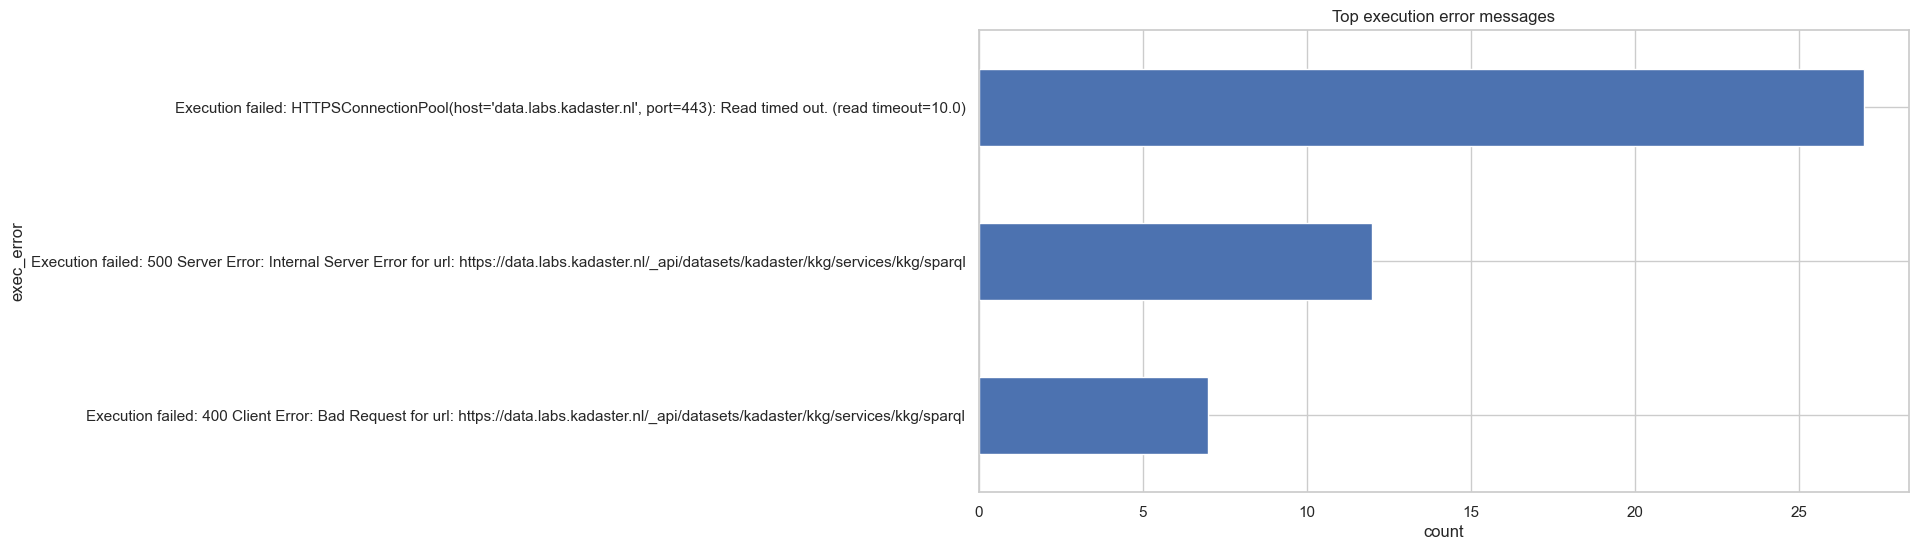

In [79]:
if len(err_counts) > 0:
    ax = err_counts.sort_values(ascending=True).plot(kind="barh")
    ax.set_title("Top execution error messages")
    ax.set_xlabel("count")
    plt.show()

## Query types and patterns


In [80]:
qt = df["query_type"].value_counts(dropna=False)
qt

query_type
SELECT       341
CONSTRUCT     19
None           4
ASK            1
Name: count, dtype: int64

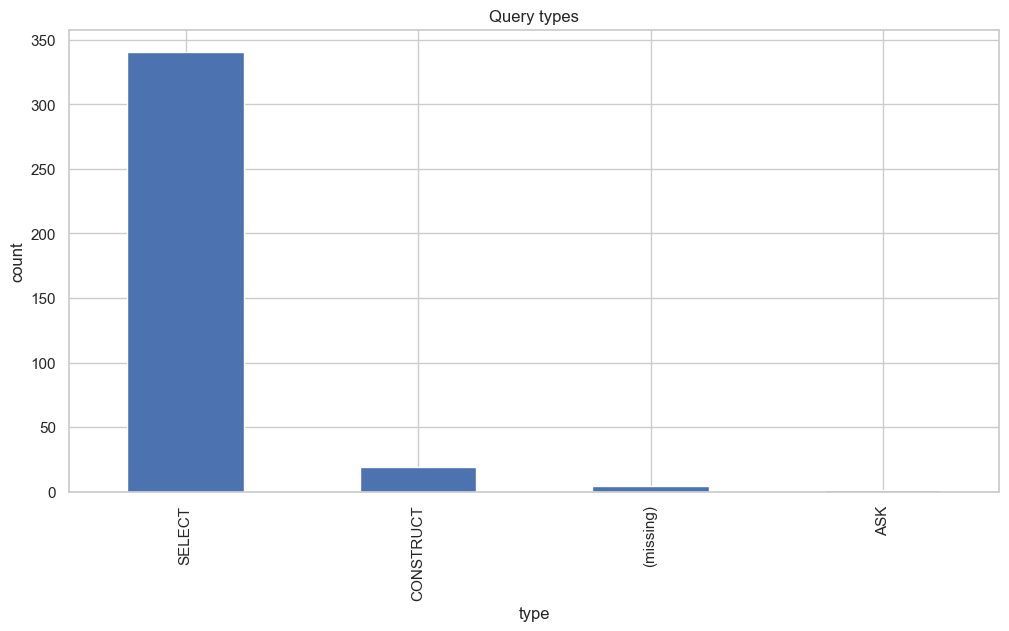

In [81]:
ax = df["query_type"].fillna("(missing)").value_counts().plot(kind="bar")
ax.set_title("Query types")
ax.set_xlabel("type")
ax.set_ylabel("count")
plt.show()

In [82]:
service_rate = df.groupby("query_type")["has_service"].mean().sort_values(ascending=False)
service_rate

query_type
SELECT       0.228739
CONSTRUCT    0.157895
ASK          0.000000
Name: has_service, dtype: float64

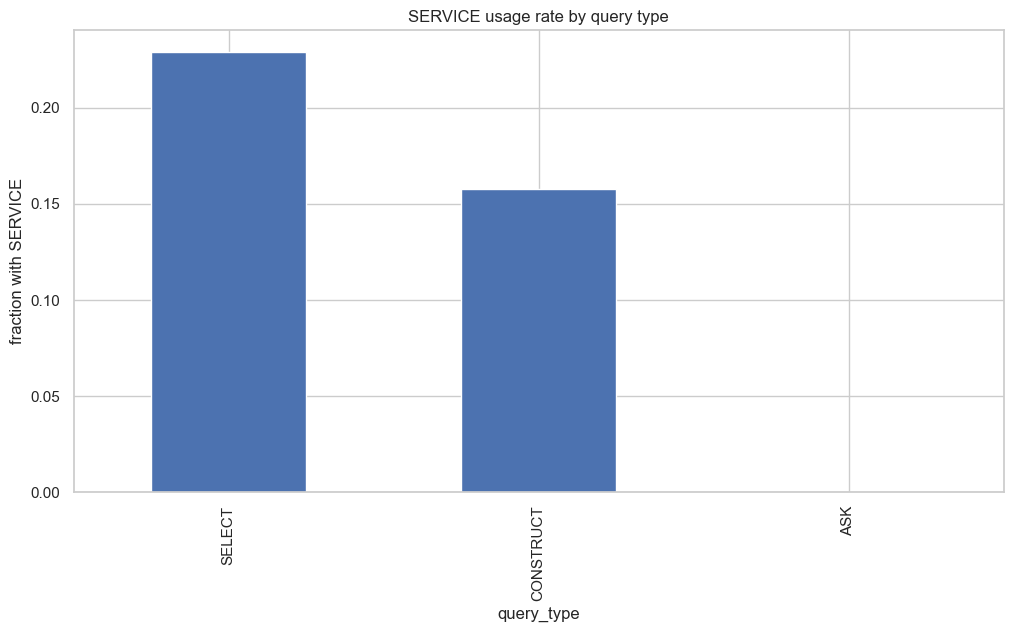

In [83]:
ax = service_rate.plot(kind="bar")
ax.set_title("SERVICE usage rate by query type")
ax.set_xlabel("query_type")
ax.set_ylabel("fraction with SERVICE")
plt.show()

## Query length and LIMITs


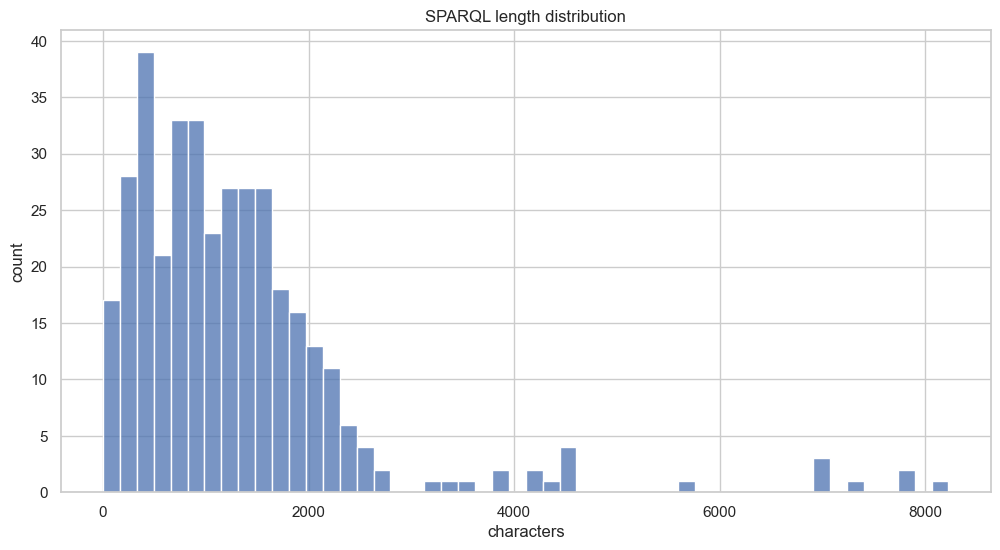

In [84]:
sns.histplot(df["sparql_len"], bins=50)
plt.title("SPARQL length distribution")
plt.xlabel("characters")
plt.ylabel("count")
plt.show()

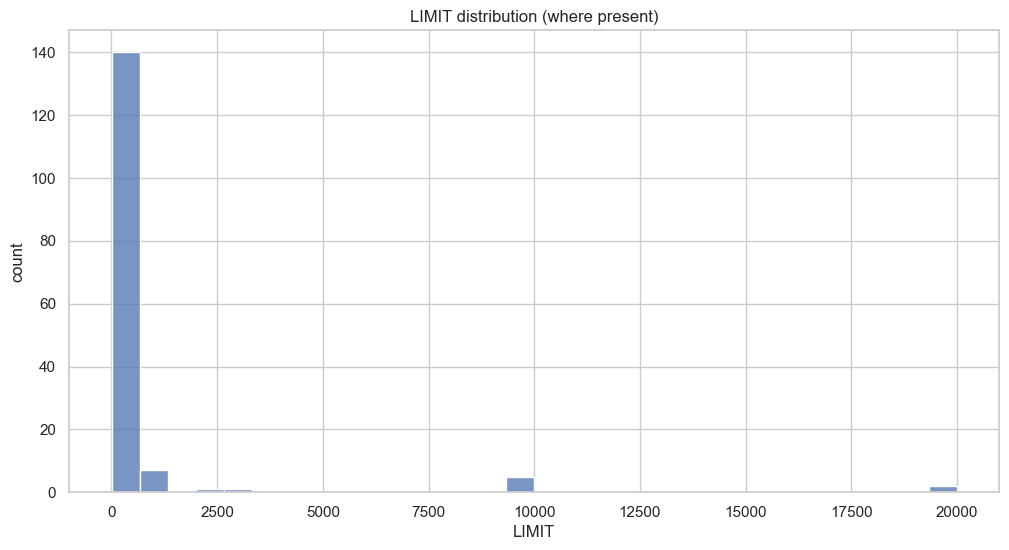

In [85]:
sns.histplot(df["limit"].dropna(), bins=30)
plt.title("LIMIT distribution (where present)")
plt.xlabel("LIMIT")
plt.ylabel("count")
plt.show()

## Prefix usage

There are two sources:
- `prompt_context.prefixes` (from the dataset metadata)
- `PREFIX` declarations directly inside the query text


In [86]:
declared = Counter()
for decls in df["declared_prefixes"]:
    for pfx, iri in decls:
        declared[pfx] += 1

top_declared = pd.Series(dict(declared)).sort_values(ascending=False).head(25)
top_declared

rdf           242
rdfs          240
geo           211
skos          172
sor           134
bag            90
nen3610        88
bif            72
xsd            58
foaf           58
kad            58
sdo            49
imxgeo         48
brt            45
bgt            43
wbk            42
dct            36
prov           36
ext            28
owl            23
geof           23
kad-con        21
uom            18
kwaliteit      15
typeGebouw     15
dtype: int64

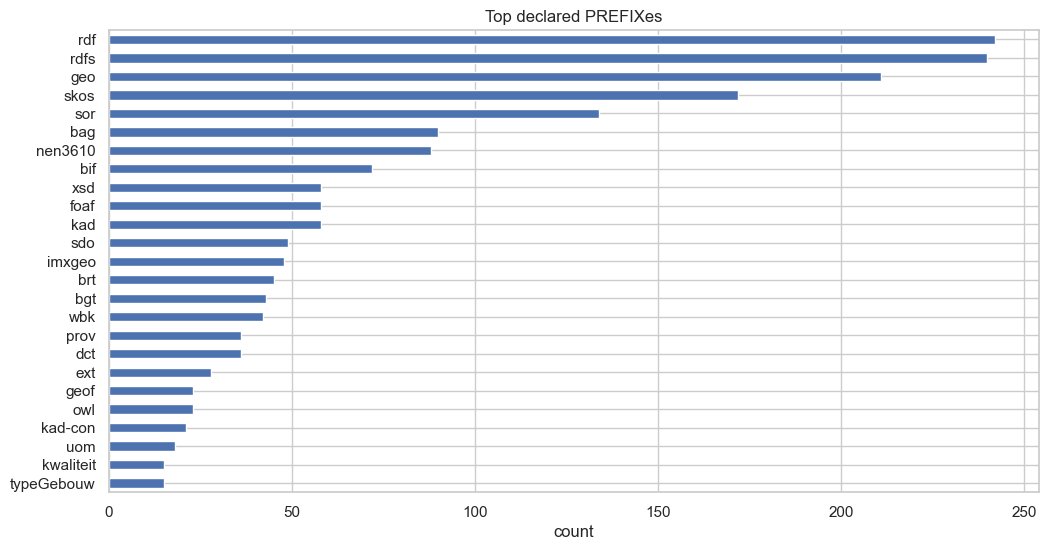

In [87]:
if len(top_declared) > 0:
    ax = top_declared.sort_values(ascending=True).plot(kind="barh")
    ax.set_title("Top declared PREFIXes")
    ax.set_xlabel("count")
    plt.show()

## Metadata distributions


In [88]:
df[["meta_owner", "meta_visualization", "prompt_context_dataset_name"]].describe(include="all")

,meta_owner,meta_visualization,prompt_context_dataset_name
count,365,361,365
unique,24,15,33
top,Data Science Team (DST),table,Unknown
freq,141,108,197


In [89]:
top_owners = df["meta_owner"].fillna("(missing)").value_counts().head(20)
top_owners

meta_owner
Data Science Team (DST)                                         141
Kadaster                                                         35
Basisregistratie Adressen en Gebouwen (BAG)                      33
High2x2 - #Energie                                               22
LADM                                                             16
Hans Schevers                                                    16
Basisregistratie Topografie (BRT)                                14
Basisregistratie Grootschalige Topografie (BGT)                  11
Lexi Rowland                                                     10
hack-a-LOD                                                       10
Centraal Bureau voor de Statistiek (CBS)                          9
Wouter Beek                                                       8
Kadaster Staging Environment                                      7
GeoData Wizard                                                    6
Basisregistratie Kadaster (BRK)      

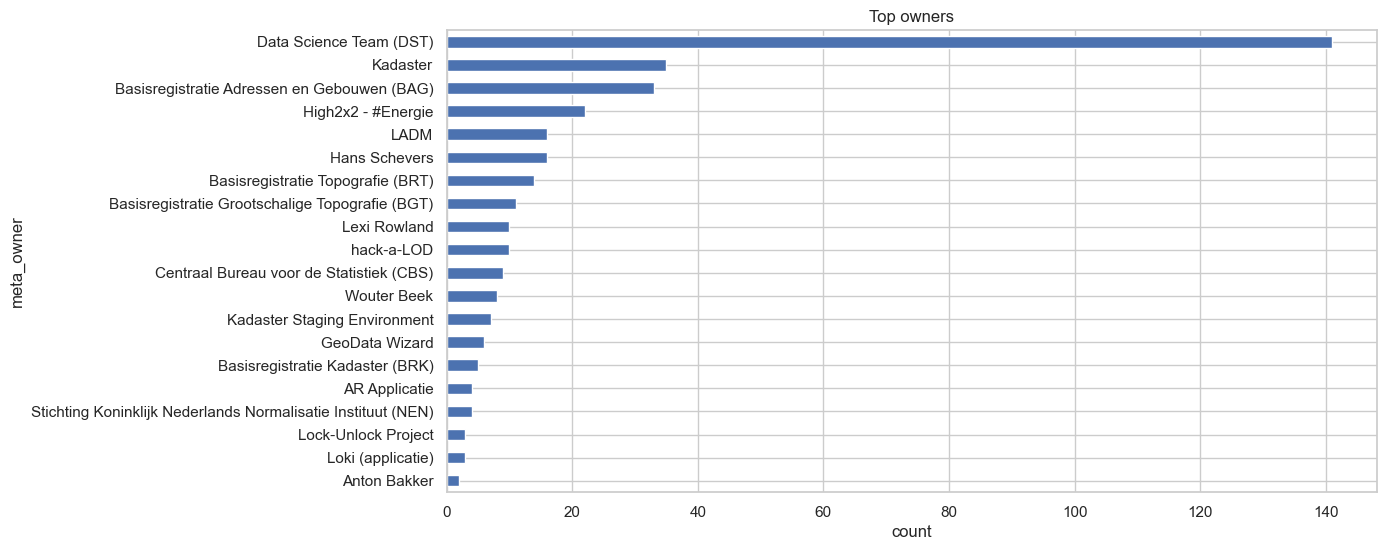

In [90]:
ax = top_owners.sort_values(ascending=True).plot(kind="barh")
ax.set_title("Top owners")
ax.set_xlabel("count")
plt.show()

In [91]:
viz = df["meta_visualization"].fillna("(missing)").value_counts().head(20)
viz

meta_visualization
table        108
geo          103
gchart        46
Geo           37
Table         25
network        8
gallery        8
geo3d          7
response       7
Charts         6
(missing)      4
Gallery        2
timeline       1
pivot          1
markup         1
Network        1
Name: count, dtype: int64

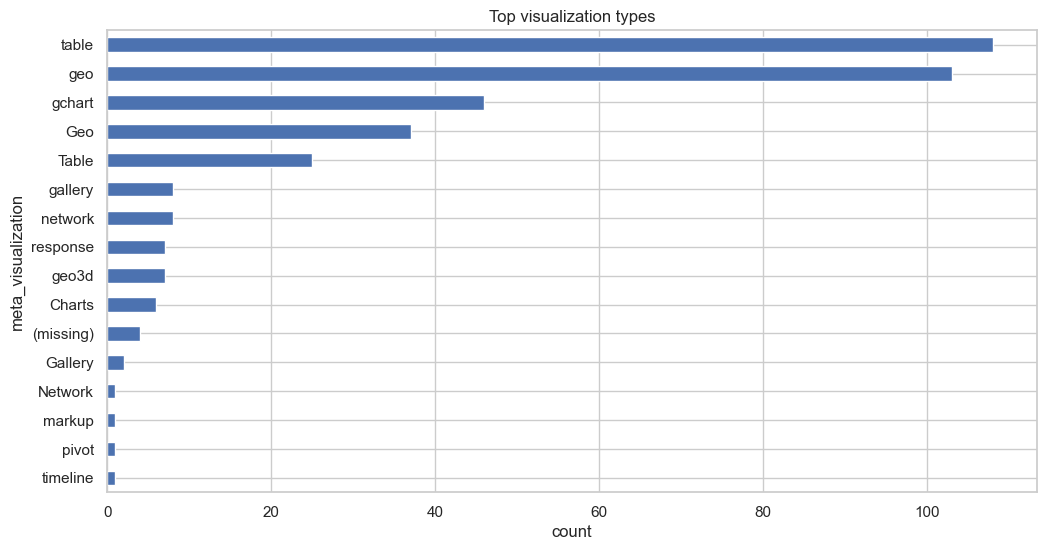

In [92]:
ax = viz.sort_values(ascending=True).plot(kind="barh")
ax.set_title("Top visualization types")
ax.set_xlabel("count")
plt.show()

## Duplicates

We compute a stable hash of the normalized query text to find duplicates.


In [93]:
import hashlib


def stable_hash(text: Any) -> str | None:
    if not isinstance(text, str) or not text.strip():
        return None
    normalized = re.sub(r"\s+", " ", text.strip())
    return hashlib.sha256(normalized.encode("utf-8")).hexdigest()


df["sparql_hash"] = df["output_sparql"].map(stable_hash)
dupe_counts = df["sparql_hash"].value_counts()
dupes = dupe_counts[dupe_counts > 1]
len(dupes), dupes.head(10)

(10,
 sparql_hash
 f21be8e4f7d78b12b1d47c57e325304fd89c329f8dbfa291281649fe0a05e50a    3
 689acbce1d3417610afe2779b8374a138946cb6b496cd4779511ad252ba108c4    3
 51b62b775db864ee761fbb81b9f44bcf84177bb2558ca73957c3108802d37e2e    2
 9eac4603f24229cba7d8e9a595bcd6301a491276e4da8eb6cdefafc6eac11029    2
 c69c2402f1514f66a78d541c6ee2ae64dfd9c03c4f70f6726eae9e7b5dc64dd7    2
 a0605f3842292a5a13432a88750f3a4f7fe94a9e32a1dfff4ce1c0828b84ff7a    2
 38cc553a7ba96498bbdd84881578983b0c1a90df5e4f7edf413053ec2c56bbfe    2
 3db18078dd84a06290915b65358c9525bc38ba85b895b4ea0b25350b6253f7a9    2
 7bcaa701dff9acca93797a9e465aad18865c9e7d8c54ccefbb6171806edc99b4    2
 54e396022151d52ee3388b80c31904d5521cfaee1c0d31e73bf8bcf05c66535c    2
 Name: count, dtype: int64)

In [94]:
if len(dupes) > 0:
    sample_hash = dupes.index[0]
    df.loc[df["sparql_hash"] == sample_hash, ["meta_id", "meta_name", "meta_owner", "query_type"]].head(20)

## Correlations / comparisons

Do longer queries fail more often? Does `SERVICE` correlate with errors? Use quick groupby summaries.


In [95]:
df["is_error"] = df["exec_class"].eq("error")
df["is_empty"] = df["exec_class"].eq("empty")

summary = df.groupby(["query_type", "has_service"]).agg(
    n=("meta_id", "count"),
    error_rate=("is_error", "mean"),
    empty_rate=("is_empty", "mean"),
    mean_len=("sparql_len", "mean"),
    median_len=("sparql_len", "median"),
).reset_index()

summary.sort_values(["n"], ascending=False).head(20)

,query_type,has_service,n,error_rate,empty_rate,mean_len,median_len
3,SELECT,False,263,0.095057,0.745247,1229.737643,962.0
4,SELECT,True,78,0.256410,0.679487,1419.397436,1285.0
1,CONSTRUCT,False,16,0.062500,0.000000,1798.125000,610.0
2,CONSTRUCT,True,3,0.000000,0.000000,4471.000000,4471.0
0,ASK,False,1,0.000000,0.000000,107.000000,107.0


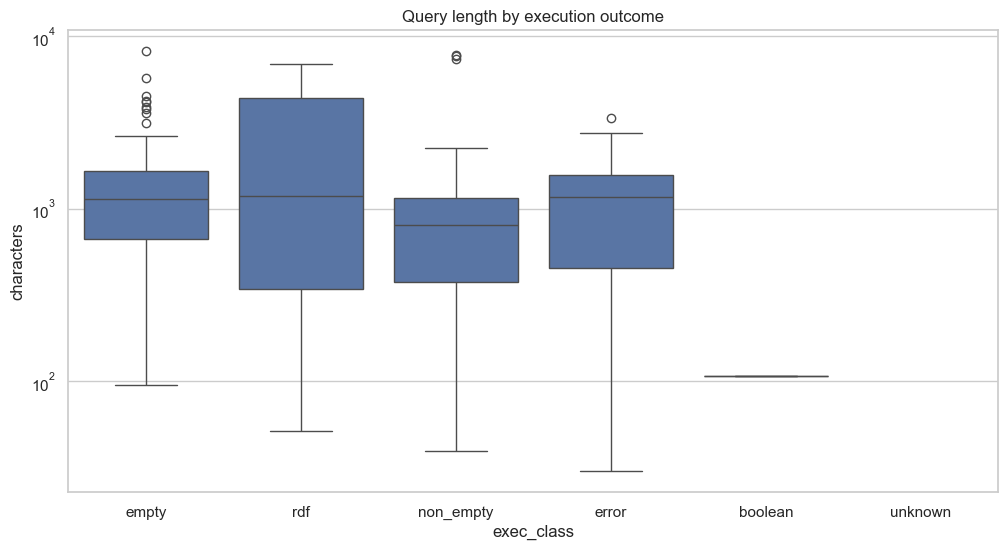

In [96]:
sns.boxplot(data=df, x="exec_class", y="sparql_len")
plt.title("Query length by execution outcome")
plt.xlabel("exec_class")
plt.ylabel("characters")
plt.yscale("log")
plt.show()

## Spot check examples

Inspect a few failing or empty-result queries to decide what to filter/curate for few-shot contexts.


In [97]:
cols = ["meta_id", "meta_name", "query_type", "has_service", "limit", "sparql_len", "exec_class", "exec_error"]

df.loc[df["exec_class"].eq("error"), cols].head(20)

,meta_id,meta_name,query_type,has_service,limit,sparql_len,exec_class,exec_error
40,62b8348f0fe5bf1b8a9b144b,kwaliteit-panden-gemeente,SELECT,True,1000.0,1348,error,Execution failed: 400 Client Error: Bad Reques...
41,62b83a46513bdbee6ba4a79e,kwaliteit-verblijfsobject,SELECT,True,500.0,1422,error,Execution failed: 400 Client Error: Bad Reques...
50,62b8706b513bdbee6ba7c1e6,brt-era,SELECT,True,NaN,1031,error,Execution failed: 500 Server Error: Internal S...
52,62b87130513bdbee6ba7ce6d,station-info,SELECT,True,1.0,1104,error,Execution failed: 500 Server Error: Internal S...
53,62b871820fe5bf1b8a9f0ba1,era-spoor,SELECT,True,NaN,407,error,Execution failed: 500 Server Error: Internal S...
54,62b871f00fe5bf1b8a9f1216,brt-era-sporen,SELECT,True,NaN,1563,error,Execution failed: 500 Server Error: Internal S...
55,62b87252513bdbee6ba7de43,era-track,SELECT,True,1.0,812,error,Execution failed: 500 Server Error: Internal S...
56,62b87546513bdbee6ba8047e,bag-postcode-huisnummer,SELECT,False,250.0,2066,error,Execution failed: HTTPSConnectionPool(host='da...
100,62c449f26e03182b49b34b25,brt-bunker-poi,SELECT,False,1.0,835,error,Execution failed: 500 Server Error: Internal S...
113,62c4776b0d58f7772033d680,igo-aantal-beperkingen-totaal,SELECT,False,500.0,2355,error,Execution failed: 400 Client Error: Bad Reques...


In [98]:
df.loc[df["exec_class"].eq("empty"), cols].head(20)

,meta_id,meta_name,query_type,has_service,limit,sparql_len,exec_class,exec_error
0,62b327c30e997990799accd3,recommender-system,SELECT,False,NaN,1554,empty,None
2,62b328e60e997990799ace5d,word-counts,SELECT,False,10.0,230,empty,None
4,62b338c30e997990799ae29d,voorzieningen-vergelijking,SELECT,False,NaN,837,empty,None
5,62b3399c5be4191ce3b65f3e,bevolkingssamenstelling,SELECT,False,NaN,3786,empty,None
6,62b33af20e997990799ae591,woningwaarde,SELECT,False,NaN,1568,empty,None
7,62b346430e997990799aee5d,reeele-energiebesparing,SELECT,True,NaN,1087,empty,None
8,62b346ec0e997990799aef2f,energiebesparing-fysische-maatregelen,SELECT,True,NaN,1138,empty,None
9,62b347680e997990799aefd4,energiebesparing-installatietechnisch,SELECT,True,NaN,1157,empty,None
10,62b34d0c5be4191ce3b66867,aantal-meldingen-per-gemeente,SELECT,False,NaN,1440,empty,None
11,62b34d7a5be4191ce3b668b5,schades-per-gemeente,SELECT,False,NaN,237,empty,None


## Export a compact summary

Creates a CSV you can use for filtering/curation.


In [99]:
out = df.copy()
out["meta_description"] = out.get("meta_description", pd.Series([None] * len(out))).astype("string")

summary_cols = [
    "meta_id",
    "meta_name",
    "meta_owner",
    "meta_visualization",
    "prompt_context_dataset_name",
    "query_type",
    "has_service",
    "limit",
    "sparql_len",
    "declared_prefix_count",
    "prefix_count",
    "exec_class",
    "exec_error",
]

csv_path = Path("kadaster_summary.csv")
out[summary_cols].to_csv(csv_path, index=False)
csv_path

WindowsPath('kadaster_summary.csv')